In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
import keras_nlp

from sentence_transformers import SentenceTransformer, InputExample, losses

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler
import torch.nn.functional as F
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')


In [ ]:
#!pip install info-nce-pytorch

## Data Load

In [3]:
df_train = pd.read_csv('/kaggle/input/job-vacancy-train/train.csv')

In [7]:
df_train

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
...,...,...,...
6236,SummaryResults-driven Data Entry Clerk with ex...,"Hi,\nHope you are doing great today. Please fi...",Good Fit
6237,Professional SummaryWith the attitude of learn...,Job Title: DHT - Front End Software Engineer W...,Good Fit
6238,Summary• \nOver\nThree years of extensi...,LHH Recruitment Solutions is looking for a Sof...,Good Fit
6239,ProfileAbility to prioritize and multi-task in...,Our client is a growing Medical Device company...,Good Fit


In [4]:
df_test = pd.read_csv('/kaggle/input/job-vacancy-test/test.csv')

In [3]:
df_test.iloc[1758]['job_description_text']

"Title: Sr. Data EngineerLocation: Austin, TxDuration: 6 MonthsPay Rate: $65HR - $70HR on W2\nRequirements:Bachelors degree in Computer Science or related field plus 4+ years of relevant work experience or a Master's degree plus 2+ years of relevant work experience or a PhD plus 0-1 years of relevant experienceIn lieu of a degree, qualified candidates would require 8+ years of relevant professional experienceExcellent with SQLExcellent programming skills in Python and ideally demonstrating an aptitude via experience with multiple languagesExcellent understanding of patterns for data ingest into data warehouse, ingest, cleansing, standardizing, etc., in addition to different data structures like normalized, denormalized, starExcellent experience supporting Snowflake Data Warehouse, including Snowpipe (including streams), tasks, transformations, views, dynamic tables. This should include advanced skills in ensuring efficient utilization of Snowflake compute and the ability to optimize wo

In [5]:
df_train['label'] = df_train['label'].replace('Potential Fit', 'Good Fit')
df_test['label'] = df_test['label'].replace('Potential Fit', 'Good Fit')

In [ ]:
df_train['job_description_text'].nunique()

In [8]:
df_train.shape

(6241, 3)

In [6]:
class_labels = df_train["label"].unique()
class_labels

array(['No Fit', 'Good Fit'], dtype=object)

In [7]:
df_train.drop_duplicates(inplace=True)

In [8]:
df_train['label_int'] = df_train['label'].map({'Good Fit': 1, 'No Fit': 0})
df_test['label_int'] = df_test['label'].map({'Good Fit': 1, 'No Fit': 0})

## Model Creation

In [9]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "princeton-nlp/sup-simcse-roberta-base"
BATCH_SIZE = 32
EPOCHS = 15
MAX_LENGTH = 256

class ResumeJobDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        resume = self.df.iloc[idx]['resume_text_clean']
        job = self.df.iloc[idx]['job_description_text_clean']
        label = self.df.iloc[idx]['label_int']

        resume_enc = self.tokenizer(resume, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        job_enc = self.tokenizer(job, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")

        return {
            'resume_input_ids': resume_enc['input_ids'].squeeze(0),
            'resume_attention_mask': resume_enc['attention_mask'].squeeze(0),
            'job_input_ids': job_enc['input_ids'].squeeze(0),
            'job_attention_mask': job_enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }


class SiameseSimCSE(nn.Module):
    def __init__(self, model_name, freeze_percentage=0.8):
        super(SiameseSimCSE, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        total_layers = len(self.encoder.encoder.layer)
        layers_to_freeze = int(total_layers * freeze_percentage)

        for param in self.encoder.parameters():
            param.requires_grad = False 

        for i in range(layers_to_freeze, total_layers):
            for param in self.encoder.encoder.layer[i].parameters():
                param.requires_grad = True 

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = output.last_hidden_state[:, 0] 
        embeddings = F.normalize(embeddings, p=2, dim=1)  
        return embeddings


def compute_cosine_similarity(a, b):
    return F.cosine_similarity(a, b)


def compute_accuracy(similarities, labels, threshold=0.5):
    preds = (similarities > threshold).float()
    return (preds == labels).float().mean().item()






## Data Preproc + Tokenization

In [ ]:
class TransformerPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words_en = set(stopwords.words('english'))
        self.nlp = spacy.load("en_core_web_sm")
        #self.tool = language_tool_python.LanguageTool('en-US')

    # def correct_grammar(self, text):
    #     try:
    #         matches = self.tool.check(text)
    #         return language_tool_python.utils.correct(text, matches)
    #     except Exception:
    #         return text

    def remove_urls(self, text):
        return re.sub(r'http[s]?://\S+|www\.\S+', '<url>', text)


    def clean_text(self, text):
        text = text.lower() 
        text = self.remove_urls(text)
        text = re.sub(r"<[^>]+>", " ", text)
        text = re.sub(r'\bsummary(?=\S)', 'summary ', text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"[^\w\s\.,'!?]", '', text)
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clean_text(text) for text in X]

In [ ]:
preprocessor = Pipeline([
    ('preprocessor', TransformerPreprocessor())
])

In [ ]:
df['resume_text_clean'] = preprocessor.fit_transform(df['resume_text'])
df['job_description_text_clean'] = preprocessor.fit_transform(df['job_description_text'])

In [ ]:
df_test['resume_text_clean'] = preprocessor.transform(df_test['resume_text'])
df_test['job_description_text_clean'] = preprocessor.transform(df_test['job_description_text'])

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [11]:




train_dataset = ResumeJobDataset(df_train, tokenizer)
val_dataset = ResumeJobDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)




In [30]:
model = SiameseSimCSE(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [16]:
# def compute_accuracy(resume_vecs, job_vecs):
#     
#     resume_vecs = torch.nn.functional.normalize(resume_vecs, p=2, dim=1)
#     job_vecs = torch.nn.functional.normalize(job_vecs, p=2, dim=1)

#     
#     logits = torch.matmul(resume_vecs, job_vecs.t())  # [batch_size x batch_size]

#     preds = torch.argmax(logits, dim=1)  # Найбільш схожий job для кожного resume
#     labels = torch.arange(logits.size(0)).to(resume_vecs.device)  # Правильний відповідник

#     acc = (preds == labels).float().mean().item()
#     return acc


## MSE

In [17]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

best_val_acc = 0.0
checkpoint_path = "mse_base.pth"

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    train_accuracies = []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
        job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))
        
        similarities = compute_cosine_similarity(resume_vecs, job_vecs)
        labels = batch['label'].to(device)

        loss = F.mse_loss(similarities, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        acc = compute_accuracy(similarities, labels)
        train_accuracies.append(acc)

    avg_train_loss = np.mean(train_losses)
    avg_train_acc = np.mean(train_accuracies)
    all_train_losses.append(avg_train_loss)
    all_train_accuracies.append(avg_train_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f}")

    model.eval()
    val_losses = []
    val_accuracies = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
            job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))
            
            similarities = compute_cosine_similarity(resume_vecs, job_vecs)
            labels = batch['label'].to(device)

            val_loss = F.mse_loss(similarities, labels)
            val_losses.append(val_loss.item())

            acc = compute_accuracy(similarities, labels)
            val_accuracies.append(acc)

    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)
    all_val_losses.append(avg_val_loss)
    all_val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model at Epoch {epoch+1} with Validation Accuracy: {best_val_acc:.4f}")



Training Epoch 1: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 1 | Train Loss: 0.2085 | Train Accuracy: 0.6662


Validating Epoch 1: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 1 | Validation Loss: 0.2052 | Validation Accuracy: 0.6926
Saved best model at Epoch 1 with Validation Accuracy: 0.6926


Training Epoch 2: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 2 | Train Loss: 0.1711 | Train Accuracy: 0.7436


Validating Epoch 2: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 2 | Validation Loss: 0.1939 | Validation Accuracy: 0.6931
Saved best model at Epoch 2 with Validation Accuracy: 0.6931


Training Epoch 3: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 3 | Train Loss: 0.1518 | Train Accuracy: 0.7798


Validating Epoch 3: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 3 | Validation Loss: 0.1973 | Validation Accuracy: 0.7163
Saved best model at Epoch 3 with Validation Accuracy: 0.7163


Training Epoch 4: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 4 | Train Loss: 0.1382 | Train Accuracy: 0.8072


Validating Epoch 4: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 4 | Validation Loss: 0.1937 | Validation Accuracy: 0.7044


Training Epoch 5: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 5 | Train Loss: 0.1245 | Train Accuracy: 0.8362


Validating Epoch 5: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 5 | Validation Loss: 0.1970 | Validation Accuracy: 0.7243
Saved best model at Epoch 5 with Validation Accuracy: 0.7243


Training Epoch 6: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 6 | Train Loss: 0.1070 | Train Accuracy: 0.8641


Validating Epoch 6: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 6 | Validation Loss: 0.1885 | Validation Accuracy: 0.7271
Saved best model at Epoch 6 with Validation Accuracy: 0.7271


Training Epoch 7: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 7 | Train Loss: 0.0947 | Train Accuracy: 0.8899


Validating Epoch 7: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 7 | Validation Loss: 0.2024 | Validation Accuracy: 0.7163


Training Epoch 8: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 8 | Train Loss: 0.0879 | Train Accuracy: 0.8970


Validating Epoch 8: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 8 | Validation Loss: 0.2032 | Validation Accuracy: 0.7208


Training Epoch 9: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 9 | Train Loss: 0.0814 | Train Accuracy: 0.9053


Validating Epoch 9: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 9 | Validation Loss: 0.2116 | Validation Accuracy: 0.7180


Training Epoch 10: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 10 | Train Loss: 0.0770 | Train Accuracy: 0.9122


Validating Epoch 10: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 10 | Validation Loss: 0.2141 | Validation Accuracy: 0.7214


Training Epoch 11: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 11 | Train Loss: 0.0713 | Train Accuracy: 0.9237


Validating Epoch 11: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 11 | Validation Loss: 0.2173 | Validation Accuracy: 0.7294
Saved best model at Epoch 11 with Validation Accuracy: 0.7294


Training Epoch 12: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 12 | Train Loss: 0.0696 | Train Accuracy: 0.9208


Validating Epoch 12: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 12 | Validation Loss: 0.2283 | Validation Accuracy: 0.7163


Training Epoch 13: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 13 | Train Loss: 0.0644 | Train Accuracy: 0.9337


Validating Epoch 13: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 13 | Validation Loss: 0.2288 | Validation Accuracy: 0.6975


Training Epoch 14: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 14 | Train Loss: 0.0611 | Train Accuracy: 0.9377


Validating Epoch 14: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 14 | Validation Loss: 0.2318 | Validation Accuracy: 0.7157


Training Epoch 15: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 15 | Train Loss: 0.0575 | Train Accuracy: 0.9437


Validating Epoch 15: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 15 | Validation Loss: 0.2301 | Validation Accuracy: 0.7203


Training Epoch 16: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 16 | Train Loss: 0.0539 | Train Accuracy: 0.9479


Validating Epoch 16: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 16 | Validation Loss: 0.2268 | Validation Accuracy: 0.7157


Training Epoch 17: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 17 | Train Loss: 0.0528 | Train Accuracy: 0.9505


Validating Epoch 17: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 17 | Validation Loss: 0.2325 | Validation Accuracy: 0.7231


Training Epoch 18: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 18 | Train Loss: 0.0494 | Train Accuracy: 0.9530


Validating Epoch 18: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 18 | Validation Loss: 0.2323 | Validation Accuracy: 0.7231


Training Epoch 19: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 19 | Train Loss: 0.0467 | Train Accuracy: 0.9575


Validating Epoch 19: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 19 | Validation Loss: 0.2393 | Validation Accuracy: 0.7185


Training Epoch 20: 100%|██████████| 195/195 [03:06<00:00,  1.05it/s]


Epoch 20 | Train Loss: 0.0454 | Train Accuracy: 0.9585


Validating Epoch 20: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]

Epoch 20 | Validation Loss: 0.2348 | Validation Accuracy: 0.7203


In [ ]:
torch_ligtning

In [ ]:
cosent

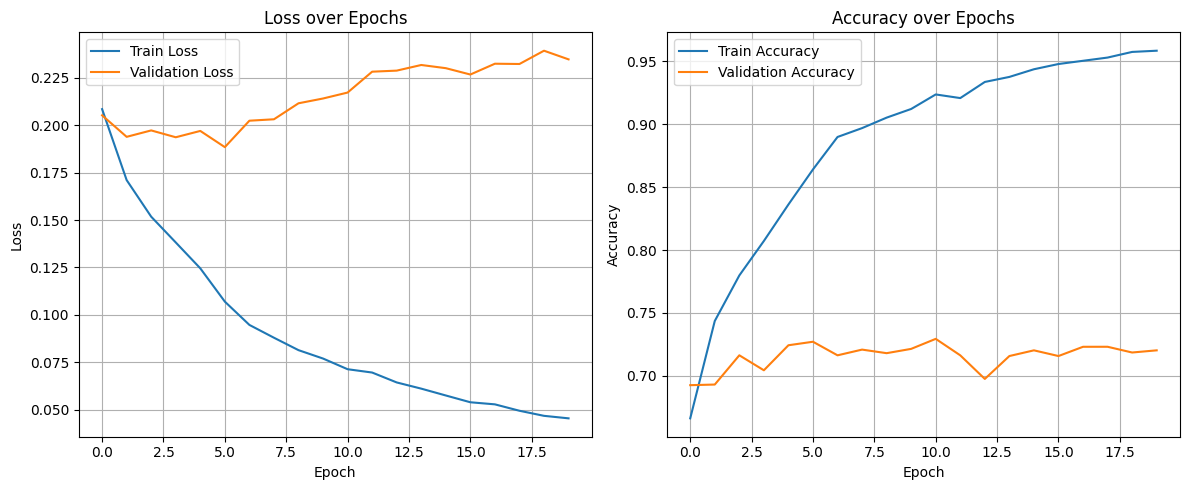

In [18]:
plt.figure(figsize=(12, 5))

# Графік Loss
plt.subplot(1, 2, 1)
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Графік Accuracy
plt.subplot(1, 2, 2)
plt.plot(all_train_accuracies, label='Train Accuracy')
plt.plot(all_val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
jkjlklkk;

## MSE model eval

In [12]:
model_load = SiameseSimCSE(MODEL_NAME).to(device)
model_load.load_state_dict(torch.load("/kaggle/working/mse_base.pth"))
model_load.eval()

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

SiameseSimCSE(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [28]:
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm

def compute_precision_at_k(model, val_dataset, tokenizer, k=10, device='cuda'):
    model.eval()

    all_resume_vecs = []
    all_job_vecs = []
    all_labels = []
    all_job_texts = []

    for i in tqdm(range(len(val_dataset)), desc="Embedding validation dataset"):
        sample = val_dataset[i]

        resume_input_ids = sample['resume_input_ids'].unsqueeze(0).to(device)
        resume_attention_mask = sample['resume_attention_mask'].unsqueeze(0).to(device)
        with torch.no_grad():
            resume_vec = model(resume_input_ids, resume_attention_mask)

        job_input_ids = sample['job_input_ids'].unsqueeze(0).to(device)
        job_attention_mask = sample['job_attention_mask'].unsqueeze(0).to(device)
        with torch.no_grad():
            job_vec = model(job_input_ids, job_attention_mask)

        all_resume_vecs.append(resume_vec.cpu())
        all_job_vecs.append(job_vec.cpu())
        all_labels.append(sample['label'].item())
        all_job_texts.append(val_dataset.df.iloc[i]['job_description_text'])

    resume_vecs = torch.cat(all_resume_vecs)
    job_vecs = torch.cat(all_job_vecs)
    labels = np.array(all_labels)

    job_to_indices = defaultdict(list)
    for idx, job_text in enumerate(all_job_texts):
        job_to_indices[job_text].append(idx)

    precisions = []

    for job_text, indices in job_to_indices.items():
        if len(indices) < k:
            continue  
        job_vector = job_vecs[indices[0]]  
        resumes = resume_vecs[indices]

        sims = torch.nn.functional.cosine_similarity(resumes, job_vector.unsqueeze(0))

        topk_idx = sims.topk(k=k).indices
        topk_labels = labels[np.array(indices)[topk_idx]]

        precision_at_k = np.mean(topk_labels == 1)
        precisions.append(precision_at_k)

    return np.mean(precisions)


In [29]:
precision_at_10 = compute_precision_at_k(model_load, val_dataset, tokenizer=tokenizer, k=10, device=device)
print(f"Precision@10 на валідаційній вибірці: {precision_at_10:.4f}")


Embedding validation dataset: 100%|██████████| 1759/1759 [00:55<00:00, 31.56it/s]


Precision@10 на валідаційній вибірці: 0.7543


In [13]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0)
        }

def embed_texts_batched(texts, model, tokenizer, device, batch_size=32):
    dataset = TextDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Embedding texts"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            embeddings = model(input_ids, attention_mask)
            embeddings = embeddings.cpu()  # обов'язково знімати з GPU

            all_embeddings.append(embeddings)

    return torch.cat(all_embeddings, dim=0)


In [14]:
torch.cuda.empty_cache()

In [16]:
df_train['job_description_text'][0]

"Net2Source Inc. is an award-winning total workforce solutions company recognized by Staffing Industry Analysts for our accelerated growth of 300% in the last 3 years with over 5500+ employees globally, with over 30+ locations in the US and global operations in 32 countries. We believe in providing staffing solutions to address the current talent gap  Right Talent  Right Time  Right Place  Right Price and acting as a Career Coach to our consultants.  \nRole: Basel Business AnalystLocation: Washington, D.C.Work Mode: HybridHire Type: 6+ Month Contract (extendable)\nJD: Role Specific Experience: 6+ years of relevant technical and business work experience The Candidates who have worked on Basel related projects in Credit risks or at least are aware of credit risk.  Banking & Financial domain experience, along with knowledge of risk management, familiarity with concepts of finance and accounting  Proficiency in MS Excel  Experience in defining and implementing technology solutions for a ma

In [17]:
embeddings = embed_texts_batched(df_train['job_description_text'][0], model_load, tokenizer, device)

Embedding texts: 100%|██████████| 124/124 [01:01<00:00,  2.03it/s]


In [ ]:
print(list(embeddings))

In [ ]:
.to_excel('resume_embeddings_mse.xlsx', index=False)

In [18]:
resume_embeddings = embed_texts_batched(df_test['resume_text'].tolist(), model_load, tokenizer, device)
resume_embeddings

Embedding texts: 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


tensor([[-0.0127, -0.0097, -0.0035,  ..., -0.0385, -0.0147, -0.0629],
        [ 0.0020, -0.0006,  0.0044,  ..., -0.0029, -0.0268, -0.0603],
        [ 0.0096, -0.0154,  0.0111,  ...,  0.0022, -0.0124,  0.0658],
        ...,
        [ 0.0328,  0.0037,  0.0179,  ...,  0.0059, -0.0073,  0.0656],
        [ 0.0134, -0.0113, -0.0129,  ..., -0.0199, -0.0230, -0.0499],
        [-0.0534, -0.0336, -0.0253,  ..., -0.0649,  0.0156, -0.0472]])

In [19]:
vacancy_embedings = embed_texts_batched(df_test['job_description_text'].tolist(), model_load, tokenizer, device)

Embedding texts: 100%|██████████| 55/55 [00:30<00:00,  1.80it/s]


In [20]:
cos_sim = F.cosine_similarity(resume_embeddings, vacancy_embedings)

preds = (cos_sim > 0.5).long().cpu().numpy()

# Істинні значення
true = df_test['label_int'].to_numpy()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, digits=4))

              precision    recall  f1-score   support

           0     0.7405    0.6628    0.6995       857
           1     0.7087    0.7794    0.7423       902

    accuracy                         0.7226      1759
   macro avg     0.7246    0.7211    0.7209      1759
weighted avg     0.7242    0.7226    0.7215      1759



In [17]:
resume_embeddings = embed_texts_batched(df_train['resume_text'].tolist(), model_load, tokenizer, device)
df_train['resume_embeddings'] = resume_embeddings.tolist()  # або залишити в тензорі, як потрібно

Embedding texts: 100%|██████████| 195/195 [01:59<00:00,  1.64it/s]


,resume_text,job_description_text,label,label_int,resume_embeddings
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit,0,"[0.0595928393304348, 0.0018512529786676168, 0...."
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit,0,"[0.0612400583922863, 0.04804038628935814, -0.0..."
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit,0,"[-0.03261592611670494, 0.019536014646291733, 0..."
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit,0,"[0.009924962185323238, 0.03182929754257202, -0..."
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit,0,"[-0.004052576143294573, 0.007266494911164045, ..."
...,...,...,...,...,...
6236,SummaryResults-driven Data Entry Clerk with ex...,"Hi,\nHope you are doing great today. Please fi...",Good Fit,1,"[-0.05335985869169235, -0.03356997296214104, -..."
6237,Professional SummaryWith the attitude of learn...,Job Title: DHT - Front End Software Engineer W...,Good Fit,1,"[-0.05406562611460686, -0.029605749994516373, ..."
6238,Summary• \nOver\nThree years of extensi...,LHH Recruitment Solutions is looking for a Sof...,Good Fit,1,"[-0.023699413985013962, 0.012601353228092194, ..."
6239,ProfileAbility to prioritize and multi-task in...,Our client is a growing Medical Device company...,Good Fit,1,"[0.010035564191639423, 0.03142399340867996, -0..."


In [26]:
df_to_save = df_train[['resume_text', 'resume_embeddings']]
df_to_save.to_excel('resume_embeddings_mse.xlsx', index=False)

In [ ]:
def embedding_to_string(embedding):
    return ','.join(map(str, embedding.cpu().numpy()))  

df_train['embedding'] = df_train['resume_embeddings'].apply(embedding_to_string)
df_embeddings = df_train[['resume_text', 'embedding']]

df_embeddings.to_excel('resume_embeddings.xlsx', index=False)

## CosineEmbedding Loss

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ініціалізація
criterion = torch.nn.CosineEmbeddingLoss(margin=0.3)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
checkpoint_path = "cosemb_base.pth"

for epoch in range(EPOCHS):
    model.train()
    epoch_train_losses = []
    epoch_train_accuracies = []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
        job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))
        
        similarities = compute_cosine_similarity(resume_vecs, job_vecs)
        labels = batch['label'].to(device)

        # Перетворення міток для CosineEmbeddingLoss
        targets = labels * 2 - 1  # 0 -> -1, 1 -> 1

        loss = criterion(resume_vecs, job_vecs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        acc = compute_accuracy(similarities, labels)
        epoch_train_accuracies.append(acc)

    avg_train_loss = np.mean(epoch_train_losses)
    avg_train_acc = np.mean(epoch_train_accuracies)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f}")

    # Validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
            job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))
            
            similarities = compute_cosine_similarity(resume_vecs, job_vecs)
            labels = batch['label'].to(device)

            targets = labels * 2 - 1  # Знову перетворення
            val_loss = criterion(resume_vecs, job_vecs, targets)
            epoch_val_losses.append(val_loss.item())

            acc = compute_accuracy(similarities, labels)
            epoch_val_accuracies.append(acc)

    avg_val_loss = np.mean(epoch_val_losses)
    avg_val_acc = np.mean(epoch_val_accuracies)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")


    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model at Epoch {epoch+1} with Validation Accuracy: {best_val_acc:.4f}")

Training Epoch 1: 100%|██████████| 195/195 [03:04<00:00,  1.06it/s]


Epoch 1 | Train Loss: 0.2711 | Train Accuracy: 0.6394


Validating Epoch 1: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 1 | Validation Loss: 0.2391 | Validation Accuracy: 0.6926
Saved best model at Epoch 1 with Validation Accuracy: 0.6926


Training Epoch 2: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 2 | Train Loss: 0.2150 | Train Accuracy: 0.7298


Validating Epoch 2: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 2 | Validation Loss: 0.2338 | Validation Accuracy: 0.6851


Training Epoch 3: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 3 | Train Loss: 0.1985 | Train Accuracy: 0.7441


Validating Epoch 3: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 3 | Validation Loss: 0.2269 | Validation Accuracy: 0.6903


Training Epoch 4: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 4 | Train Loss: 0.1894 | Train Accuracy: 0.7551


Validating Epoch 4: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 4 | Validation Loss: 0.2290 | Validation Accuracy: 0.6863


Training Epoch 5: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 5 | Train Loss: 0.1837 | Train Accuracy: 0.7575


Validating Epoch 5: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]


Epoch 5 | Validation Loss: 0.2300 | Validation Accuracy: 0.7062
Saved best model at Epoch 5 with Validation Accuracy: 0.7062


Training Epoch 6: 100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


Epoch 6 | Train Loss: 0.1769 | Train Accuracy: 0.7692


Validating Epoch 6: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch 6 | Validation Loss: 0.2386 | Validation Accuracy: 0.6754


Training Epoch 7:   6%|▌         | 12/195 [00:12<03:09,  1.04s/it]


KeyboardInterrupt: 

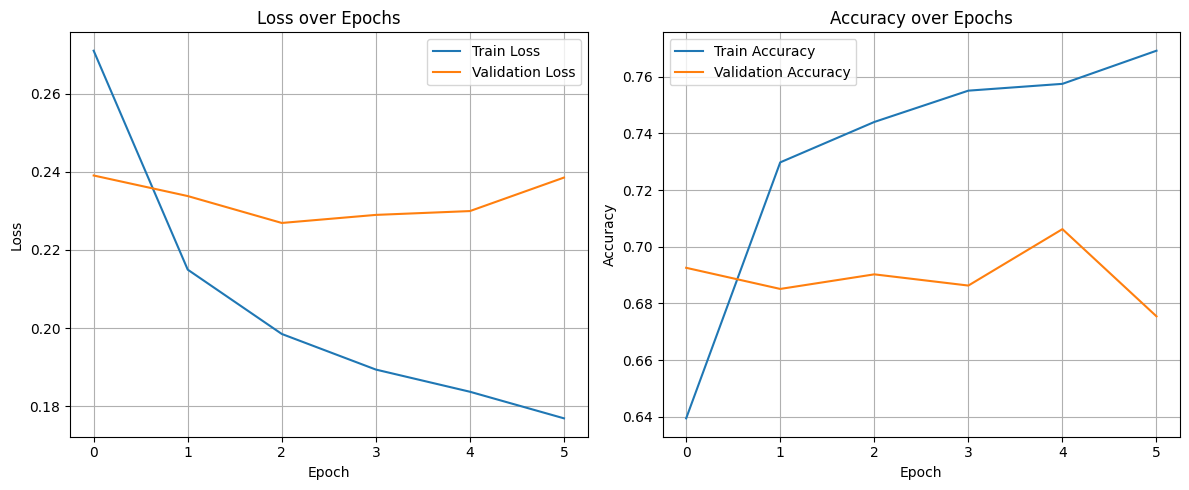

In [12]:
plt.figure(figsize=(12, 5))

# Графік Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Графік Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'simcse_cossemb.pth')

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

## InfoNCE

In [23]:
BATCH_SIZE = 32

In [24]:
def compute_info_nce_accuracy(anchors, positives):
    # anchors: [B, D], positives: [B, D]
    anchors = F.normalize(anchors, dim=1)
    positives = F.normalize(positives, dim=1)

    similarity_matrix = torch.matmul(anchors, positives.T) 
    preds = similarity_matrix.argmax(dim=1)  
    labels = torch.arange(similarity_matrix.size(0)).to(anchors.device) 

    accuracy = (preds == labels).float().mean().item()
    return accuracy


In [25]:
train_dataset_nce = ResumeJobDataset(df_train[df_train['label_int'] == 1], tokenizer)
val_dataset_nce = ResumeJobDataset(df_test[df_test['label_int']==1], tokenizer)

train_loader_nce = DataLoader(train_dataset_nce, batch_size=BATCH_SIZE, shuffle=True)
val_loader_nce = DataLoader(val_dataset_nce, batch_size=BATCH_SIZE)

In [26]:
EPOCHS = 5

In [28]:
!pip install info-nce-pytorch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [31]:

from info_nce import InfoNCE

# Ініціалізація InfoNCE loss
criterion = InfoNCE(temperature=0.05)  
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
checkpoint_path = "infoNCE.pth"

for epoch in range(EPOCHS):
    model.train()
    epoch_train_losses = []
    epoch_train_accuracies = []

    for batch in tqdm(train_loader_nce, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
        job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))

        labels = batch['label'].to(device)
        targets = labels  

        #negative_vecs = torch.cat([resume_vecs[1:], job_vecs[:-1]], dim=0)  
        loss = criterion(resume_vecs, job_vecs)

        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
        
        acc = compute_info_nce_accuracy(resume_vecs, job_vecs)
        epoch_train_accuracies.append(acc)
        

    avg_train_loss = np.mean(epoch_train_losses)
    avg_train_acc = np.mean(epoch_train_accuracies)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f}")

    # Validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []

    with torch.no_grad():
        for batch in tqdm(val_loader_nce, desc=f"Validating Epoch {epoch+1}"):
            resume_vecs = model(batch['resume_input_ids'].to(device), batch['resume_attention_mask'].to(device))
            job_vecs = model(batch['job_input_ids'].to(device), batch['job_attention_mask'].to(device))

            labels = batch['label'].to(device)

            #negative_vecs = torch.cat([resume_vecs[1:], job_vecs[:-1]], dim=0) 
            val_loss = criterion(resume_vecs, job_vecs)

            epoch_val_losses.append(val_loss.item())
            
            acc = compute_info_nce_accuracy(resume_vecs, job_vecs)
            epoch_val_accuracies.append(acc)

    avg_val_loss = np.mean(epoch_val_losses)
    avg_val_acc = np.mean(epoch_val_accuracies)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model at Epoch {epoch+1} with Validation Accuracy: {best_val_acc:.4f}")


Training Epoch 1: 100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Epoch 1 | Train Loss: 2.7846 | Train Accuracy: 0.1094


Validating Epoch 1: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Epoch 1 | Validation Loss: 2.7491 | Validation Accuracy: 0.1584
Saved best model at Epoch 1 with Validation Accuracy: 0.1584


Training Epoch 2: 100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Epoch 2 | Train Loss: 2.4870 | Train Accuracy: 0.1334


Validating Epoch 2: 100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Epoch 2 | Validation Loss: 2.7486 | Validation Accuracy: 0.1347


Training Epoch 3: 100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Epoch 3 | Train Loss: 2.3769 | Train Accuracy: 0.1420


Validating Epoch 3: 100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Epoch 3 | Validation Loss: 2.8748 | Validation Accuracy: 0.1433


Training Epoch 4: 100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Epoch 4 | Train Loss: 2.2914 | Train Accuracy: 0.1646


Validating Epoch 4: 100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Epoch 4 | Validation Loss: 3.1398 | Validation Accuracy: 0.1422


Training Epoch 5: 100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Epoch 5 | Train Loss: 2.2245 | Train Accuracy: 0.1800


Validating Epoch 5: 100%|██████████| 29/29 [00:18<00:00,  1.59it/s]

Epoch 5 | Validation Loss: 3.2918 | Validation Accuracy: 0.1343


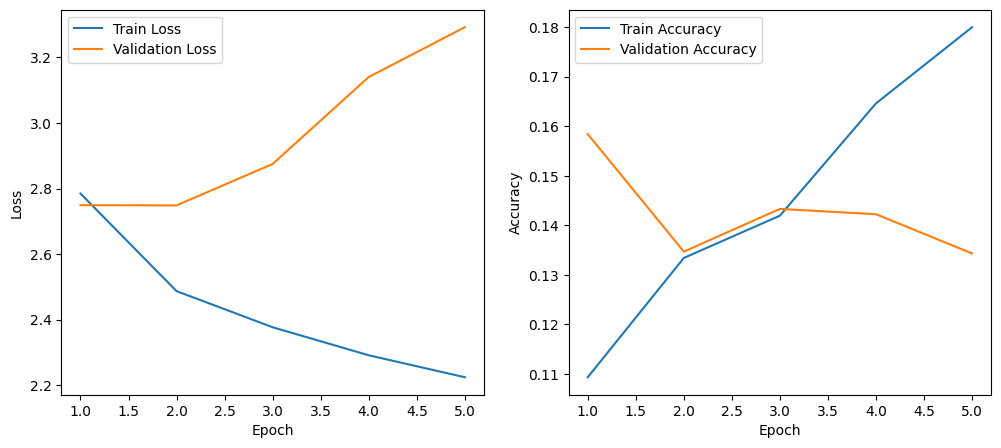

In [32]:

# Графіки втрат та точності
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
